# ベイズ推定playground

In [101]:
import sys
sys.path.append('../src')

import bayes_estimation_helper
import importlib
importlib.reload(bayes_estimation_helper)
import matplotlib.pyplot as plt
import seaborn as sns

helper = bayes_estimation_helper.SensorValueAndTimeWithBayes('../data/range_sensor/sensor_data_600.txt')

shape = (24,)
sum = 0.9999999999999999


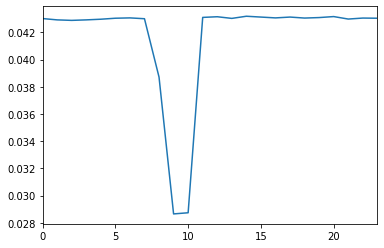

In [102]:
p_t = helper.marginalize_in('t')
print('shape = {}'.format(p_t.shape))
print('sum = {}'.format(p_t.sum()))
p_t.plot()
plt.show()

shape = (37,)
sum = 1.0


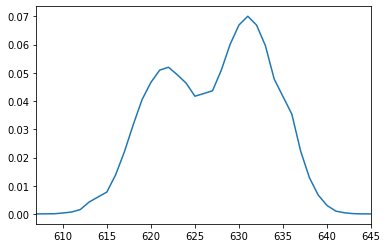

In [103]:
p_z = helper.marginalize_in('z')
print('shape = {}'.format(p_z.shape))
print('sum = {}'.format(p_z.sum()))
p_z.plot()
plt.show()

shape of joint_z_t = (37, 24)
sum of joint_z_t = 0.9999999999999999


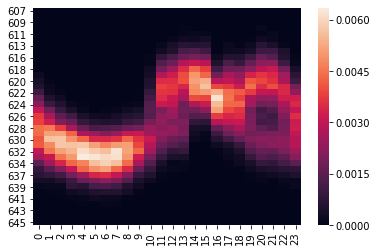

In [104]:
joint_z_t = helper.joint_z_t()
print('shape of joint_z_t = {}'.format(joint_z_t.shape))
print('sum of joint_z_t = {}'.format(joint_z_t.sum().sum()))
sns.heatmap(joint_z_t)
plt.show()

shape of cond_z_t = (37, 24)
sum of cond_z_t = 24.0
sum of cond_z_t[0] = 1.0000000000000002


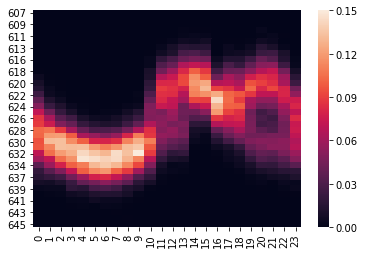

In [111]:
cond_z_t = helper.cond_z_t()
print('shape of cond_z_t = {}'.format(cond_z_t.shape))
print('sum of cond_z_t = {}'.format(cond_z_t.sum().sum()))
print('sum of cond_z_t[0] = {}'.format(cond_z_t[0].sum()))
sns.heatmap(cond_z_t)
plt.show()

shape of cond_t_z = (24, 37)
sum of cond_t_z = 37.0
sum of cond_t_z[0] = 1.0


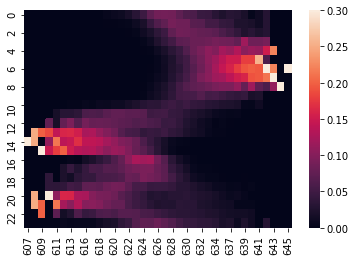

In [114]:
cond_t_z = helper.cond_t_z()
print('shape of cond_t_z = {}'.format(cond_t_z.shape))
print('sum of cond_t_z = {}'.format(cond_t_z.sum().sum()))
print('sum of cond_t_z[0] = {}'.format(cond_t_z[607].sum()))
# 分布が見えやすいように0.3で飽和させている
sns.heatmap(cond_t_z, vmax=0.3)
plt.show()